# 🏥 Medical Q&A Assistant - Fine-Tuning Learning Journey

## Project Overview
**Objective**: Fine-tune DistilGPT-2 to answer medical questions and demonstrate understanding of the training process.

**Key Focus**: Show that training improves model performance through:
- Loss reduction over epochs
- Improved evaluation metrics
- Better answer quality vs baseline

**Dataset**: MedQuAD - Medical Q&A from NIH/CDC

---

## 🎯 Learning Goals:
1. Select appropriate model, dataset, and hyperparameters
2. Track training progress with metrics
3. Evaluate fine-tuning impact
4. Compare before/after performance
5. Analyze results with appropriate metrics

---

## 1️⃣ Setup & Environment

Install libraries and configure GPU for Apple M3 Pro

In [1]:
# Install required libraries
!pip install -q transformers datasets torch accelerate evaluate rouge-score nltk lm-eval==0.4.2

In [2]:
# Import libraries
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
import evaluate
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Get the notebook directory (all outputs will be saved here)
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__")) if "__file__" in dir() else os.getcwd()
print(f"📁 Working directory: {NOTEBOOK_DIR}")
print(f"   All outputs will be saved here!\n")

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

# Configure device - Enable MPS for Apple M3 Pro GPU!
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple M3 Pro GPU (Metal Performance Shaders)")
    print("   Expected speedup: 3-5x vs CPU")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU (slower)")

print(f"\nDevice: {device}")

# Initialize run tracking - AUTO INCREMENT!
# Check existing runs in training_history folder
history_dir = './training_history'
if os.path.exists(history_dir):
    existing_runs = [f for f in os.listdir(history_dir) if f.startswith('training_summary_run')]
    if existing_runs:
        # Extract run numbers and get the max
        run_numbers = [int(f.split('run')[1].split('.')[0]) for f in existing_runs]
        next_run = max(run_numbers) + 1
    else:
        next_run = 1
else:
    next_run = 1

RUN_CONFIG = {
    "run_number": next_run,  # Auto-incremented based on history!
    "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "device": str(device),
    "pytorch_version": torch.__version__,
    "transformers_version": transformers.__version__
}

print(f"\n📊 Run #{RUN_CONFIG['run_number']} initialized (auto-detected)")
print(f"   Previous runs found: {next_run - 1}")
print(f"   All history saved to: training_history/")
print(f"   Remember to update TRAINING_RUNS_LOG.md after training!")

📁 Working directory: /Users/ryanteooo/Documents/GitHub/GENAI-Assignment-1/Medical_QA_Simplified
   All outputs will be saved here!

PyTorch version: 2.8.0
Transformers version: 4.55.4
✅ Using Apple M3 Pro GPU (Metal Performance Shaders)
   Expected speedup: 3-5x vs CPU

Device: mps

📊 Run #10 initialized (auto-detected)
   Previous runs found: 9
   All history saved to: training_history/
   Remember to update TRAINING_RUNS_LOG.md after training!


## 2️⃣ Load & Prepare Dataset

Load MedQuAD dataset and create train/validation/test splits

In [3]:
# Load dataset
print("Loading MedQuAD dataset...")
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")

# Standardize column names
def standardize_columns(example):
    return {
        'question': example.get('Question') or example.get('question'),
        'answer': example.get('Answer') or example.get('answer')
    }

dataset = dataset.map(standardize_columns, remove_columns=dataset['train'].column_names)

print(f"✅ Dataset loaded: {len(dataset['train'])} examples")

# Show sample
print("\n📝 Sample Q&A:")
print("="*80)
example = dataset['train'][0]
print(f"Question: {example['question']}")
print(f"Answer: {example['answer'][:200]}...")
print("="*80)

Loading MedQuAD dataset...
✅ Dataset loaded: 16407 examples

📝 Sample Q&A:
Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?
Answer: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into b...
✅ Dataset loaded: 16407 examples

📝 Sample Q&A:
Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?
Answer: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into b...


In [4]:
# Create subset for training 
# PARAMETER TO ADJUST:
SUBSET_SIZE = 10000

# OPTIMIZED: Keep as HuggingFace Dataset
indices = np.random.choice(len(dataset['train']), SUBSET_SIZE, replace=False)
subset = dataset['train'].select(indices.tolist())  

print(f"✅ Sampled {len(subset)} rows")

# Split into train/validation/test 
from datasets import DatasetDict

train_size = int(0.7 * len(subset))
val_size = int(0.15 * len(subset))

# Create indices for splits
all_indices = list(range(len(subset)))
np.random.shuffle(all_indices)

train_indices = all_indices[:train_size]
val_indices = all_indices[train_size:train_size + val_size]
test_indices = all_indices[train_size + val_size:]

# Create splits
train_dataset_raw = subset.select(train_indices)
val_dataset_raw = subset.select(val_indices)
test_dataset_raw = subset.select(test_indices)

# Convert to DataFrames ONLY for displaying/processing (minimal overhead)
train_df = train_dataset_raw.to_pandas()
val_df = val_dataset_raw.to_pandas()
test_df = test_dataset_raw.to_pandas()

print(f"\n📊 Dataset splits:")
print(f"   Training: {len(train_df)} (70%) = 7,000 samples")
print(f"   Validation: {len(val_df)} (15%) = 1,500 samples")
print(f"   Test: {len(test_df)} (15%) = 1,500 samples")

✅ Sampled 10000 rows

📊 Dataset splits:
   Training: 7000 (70%) = 7,000 samples
   Validation: 1500 (15%) = 1,500 samples
   Test: 1500 (15%) = 1,500 samples


In [5]:
# Format data for decoder model
def format_qa_pair(question, answer):
    """Format Q&A for causal language modeling"""
    return f"Question: {question}\nAnswer: {answer}<|endoftext|>"

train_df['text'] = train_df.apply(lambda x: format_qa_pair(x['question'], x['answer']), axis=1)
val_df['text'] = val_df.apply(lambda x: format_qa_pair(x['question'], x['answer']), axis=1)
test_df['text'] = test_df.apply(lambda x: format_qa_pair(x['question'], x['answer']), axis=1)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['text']])
val_dataset = Dataset.from_pandas(val_df[['text']])
test_dataset = Dataset.from_pandas(test_df[['text']])

processed_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("✅ Data formatted and ready!")
print(f"\n📝 Training example format:\n{train_df['text'].iloc[0][:200]}...")

✅ Data formatted and ready!

📝 Training example format:
Question: What is (are) Orofaciodigital syndrome 1 ?
Answer: Orofaciodigital syndrome 1 (OFD1), also called orofaciodigital syndrome type 1, is a condition that affects the development of the oral cav...


## 3️⃣ Model Selection & Setup

**Model Choice: DistilGPT-2**

**Why DistilGPT-2?**
- ✅ Decoder architecture (perfect for text generation)
- ✅ 82M parameters (fast to train on M3 Pro)
- ✅ Pre-trained on general text (good starting point)
- ✅ Efficient: 40% smaller than GPT-2, keeps 97% performance

In [6]:
# Load model and tokenizer
MODEL_NAME = "distilgpt2"

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

print(f"✅ Model loaded!")
print(f"   Parameters: {model.num_parameters():,}")

Loading distilgpt2...
✅ Model loaded!
   Parameters: 81,912,576
✅ Model loaded!
   Parameters: 81,912,576


In [7]:
# Tokenize datasets
MAX_LENGTH = 256 

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        return_tensors=None
    )

print(f"Tokenizing with MAX_LENGTH={MAX_LENGTH}")
tokenized_datasets = processed_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing"
)

print("✅ Tokenization complete!")
print(f"   Max sequence length: {MAX_LENGTH} tokens")

Tokenizing with MAX_LENGTH=256


Tokenizing:   0%|          | 0/7000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1500 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1500 [00:00<?, ? examples/s]

✅ Tokenization complete!
   Max sequence length: 256 tokens


## 4️⃣ Baseline Performance (Before Training)

Test the base model BEFORE fine-tuning to compare later

In [8]:
# Function to generate answers
def generate_answer(model, question, max_length=200, temperature=0.7):
    """Generate answer to medical question"""
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            temperature=temperature,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "Answer:" in generated_text:
        return generated_text.split("Answer:")[1].strip()
    return generated_text

print("✅ Generation function ready!")

✅ Generation function ready!


In [9]:
# Test baseline model (before training)
print("🧪 BASELINE PERFORMANCE (Before Fine-Tuning)")
print("="*80)

baseline_test_question = test_df.iloc[0]
question = baseline_test_question['question']
actual_answer = baseline_test_question['answer']

print(f"\n❓ Question: {question}")
print(f"\n✅ Actual Answer (from dataset): {actual_answer[:200]}...")
print(f"\n🤖 BASE MODEL Answer (before training):")

baseline_answer = generate_answer(model, question, max_length=200, temperature=0.7)
print(baseline_answer)

print("\n" + "="*80)
print("💡 Notice: Base model may give generic/poor answers")
print("="*80)

# Save baseline answer for later comparison
baseline_comparison = {
    'question': question,
    'actual': actual_answer,
    'baseline': baseline_answer
}

🧪 BASELINE PERFORMANCE (Before Fine-Tuning)

❓ Question: How many people are affected by Costello syndrome ?

✅ Actual Answer (from dataset): This condition is very rare; it probably affects 200 to 300 people worldwide. Reported estimates of Costello syndrome prevalence range from 1 in 300,000 to 1 in 1.25 million people....

🤖 BASE MODEL Answer (before training):
1,100
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,0

## 5️⃣ Training Configuration

Set up training with carefully chosen hyperparameters

In [10]:
# Configure training arguments
OUTPUT_DIR = "./model_checkpoints"  # Save in notebook directory

EPOCHS = 12              
LEARNING_RATE = 7e-5       
BATCH_SIZE = 20           
GENERATION_TEMP = 0.3      

print("⚙️ RUN 10 Configuration - LARGER DATASET WITH HIGHER LR!")
print("="*80)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # Training parameters 
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,   
    
    # Learning rate 
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,               # Regularization
    warmup_ratio=0.1,                # Dynamic warmup (10% of training)
    lr_scheduler_type="cosine",      # Smooth decay
    max_grad_norm=1.0,               # Gradient clipping for stability
    
    # Evaluation 
    eval_strategy="steps",
    eval_steps=100,                  # Check every 100 steps
    save_strategy="steps",
    save_steps=200,                  # Save checkpoints
    save_total_limit=3,              # Keep only best 3
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    # Logging
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    
    # Performance 
    use_mps_device=True if str(device) == "mps" else False,
    fp16=False,  # MPS doesn't support fp16
    dataloader_num_workers=0,        # Prevent MPS issues
    
    # Reproducibility
    seed=42,
)

print("✅ TrainingArguments created!")

# OPTIMIZED: Create data collator AFTER printing (shows progress)
print("Initializing data collator...")
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal LM, not masked
)
print("✅ Data collator ready!")

# Log configuration
RUN_CONFIG.update({
    "dataset_size": len(train_df),
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "effective_batch_size": BATCH_SIZE * training_args.gradient_accumulation_steps,
    "generation_temperature": GENERATION_TEMP,
    "max_length": MAX_LENGTH,
    "weight_decay": training_args.weight_decay,
    "warmup_ratio": 0.1,
    "lr_scheduler": "cosine",
    "gradient_clip": training_args.max_grad_norm
})

print("\n📊 CONFIGURATION SUMMARY")
print("="*80)
print(f"   Dataset: {len(train_df)} samples (Run 10: 10,000 total)")
print(f"   Epochs: {EPOCHS} ✅ (Extended training)")
print(f"   Learning Rate: {LEARNING_RATE} ✅ (Higher LR for faster learning)")
print(f"   Batch Size: {BATCH_SIZE} → Effective: {BATCH_SIZE * 4} = 80 ✅ PROVEN!")
print(f"   Max Length: {MAX_LENGTH} tokens ✅ PROVEN OPTIMAL!")
print(f"   Generation Temp: {GENERATION_TEMP} ✅ Balanced precision")
print(f"   Warmup: ratio=0.1 (dynamic)")
print(f"   Gradient Clipping: {training_args.max_grad_norm}")
print(f"   LR Scheduler: Cosine decay")
print(f"   Device: {device} (MPS - M3 Pro GPU)")
print("="*80)


print("\n✅ Configuration complete! Ready for training.")

⚙️ RUN 10 Configuration - LARGER DATASET WITH HIGHER LR!
✅ TrainingArguments created!
Initializing data collator...
✅ Data collator ready!

📊 CONFIGURATION SUMMARY
   Dataset: 7000 samples (Run 10: 10,000 total)
   Epochs: 12 ✅ (Extended training)
   Learning Rate: 7e-05 ✅ (Higher LR for faster learning)
   Batch Size: 20 → Effective: 80 = 80 ✅ PROVEN!
   Max Length: 256 tokens ✅ PROVEN OPTIMAL!
   Generation Temp: 0.3 ✅ Balanced precision
   Warmup: ratio=0.1 (dynamic)
   Gradient Clipping: 1.0
   LR Scheduler: Cosine decay
   Device: mps (MPS - M3 Pro GPU)

✅ Configuration complete! Ready for training.


## 6️⃣ Training Process

Watch the model learn! Loss should decrease over time.

In [11]:
# Add early stopping callback
from transformers import EarlyStoppingCallback

# Initialize trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

print("Trainer initialized with early stopping!")
print("\nWill stop if no improvement for 4 evaluation checkpoints")
print("\nStarting training...")
print("="*80)

Trainer initialized with early stopping!

Will stop if no improvement for 4 evaluation checkpoints

Starting training...


In [12]:
# Train the model!
training_result = trainer.train()

print("="*80)
print("✅ Training complete!")
print("="*80)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,2.351400,2.119525
200,1.993300,1.943052
300,1.867500,1.861331
400,1.768300,1.808017
500,1.708900,1.774275
600,1.671500,1.752160
700,1.641100,1.739690
800,1.634400,1.732015
900,1.603700,1.727833
1000,1.611600,1.726338


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


✅ Training complete!


## 7️⃣ Training Visualization

Visualize the learning process - loss should decrease!

In [13]:
# Extract training history
log_history = trainer.state.log_history

train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

train_steps = [log['step'] for log in train_logs if 'step' in log]
train_losses = [log['loss'] for log in train_logs if 'loss' in log]

eval_steps = [log['step'] for log in eval_logs if 'step' in log]
eval_losses = [log['eval_loss'] for log in eval_logs if 'eval_loss' in log]

# Also get epoch info for eval
eval_epochs = [log['epoch'] for log in eval_logs if 'epoch' in log]

print(f"✅ Extracted training history:")
print(f"   Training steps logged: {len(train_logs)}")
print(f"   Evaluation checkpoints: {len(eval_logs)}")

✅ Extracted training history:
   Training steps logged: 21
   Evaluation checkpoints: 10


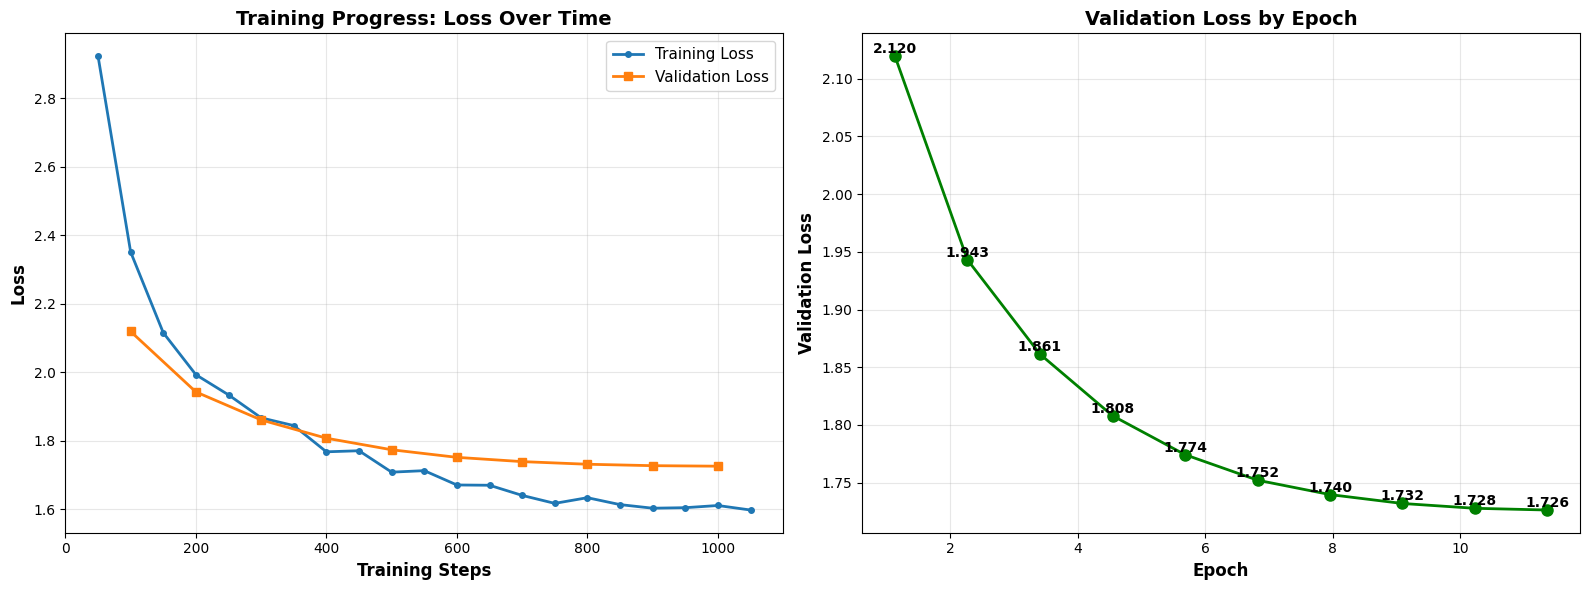


✅ Training curves saved as 'training_curves.png'

💡 Analysis:
   ✅ If loss decreases → Model is learning!
   ✅ If validation tracks training → No overfitting
   ⚠️  If validation increases → May be overfitting


In [14]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss over steps
ax1.plot(train_steps, train_losses, label='Training Loss', marker='o', markersize=4, linewidth=2)
ax1.plot(eval_steps, eval_losses, label='Validation Loss', marker='s', markersize=6, linewidth=2)
ax1.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Progress: Loss Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Loss by epoch (clearer view)
if eval_epochs:
    ax2.plot(eval_epochs, eval_losses, marker='o', markersize=8, linewidth=2, color='green')
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Validation Loss by Epoch', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for epoch, loss in zip(eval_epochs, eval_losses):
        ax2.text(epoch, loss, f'{loss:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training curves saved as 'training_curves.png'")
print("\n💡 Analysis:")
print("   ✅ If loss decreases → Model is learning!")
print("   ✅ If validation tracks training → No overfitting")
print("   ⚠️  If validation increases → May be overfitting")

## 8️⃣ Evaluation Metrics

Measure performance using appropriate metrics

In [15]:
# Evaluate on test set
print("📊 Evaluating on TEST SET (never seen during training)...")
test_results = trainer.evaluate(tokenized_datasets['test'])

print("\n✅ TEST SET RESULTS:")
print("="*80)
for key, value in test_results.items():
    print(f"   {key}: {value:.4f}")

# Calculate perplexity
import math
test_perplexity = math.exp(test_results['eval_loss'])

print(f"\n📈 Perplexity: {test_perplexity:.2f}")
print("\n💡 Perplexity Interpretation:")
print("   - Measures how 'surprised' the model is by the test data")
print("   - Lower = Better (model predicts text more confidently)")
print("   - Range: 1 to infinity")
print("="*80)

📊 Evaluating on TEST SET (never seen during training)...



✅ TEST SET RESULTS:
   eval_loss: 1.7069
   eval_runtime: 26.1256
   eval_samples_per_second: 57.4150
   eval_steps_per_second: 2.8710
   epoch: 12.0000

📈 Perplexity: 5.51

💡 Perplexity Interpretation:
   - Measures how 'surprised' the model is by the test data
   - Lower = Better (model predicts text more confidently)
   - Range: 1 to infinity


In [16]:
# ROUGE scores - measure answer similarity
print("\n📊 Calculating ROUGE Scores...")
print("(Measures overlap between generated and actual answers)")

rouge = evaluate.load('rouge')

NUM_SAMPLES = 50  # Test on 50 examples
predictions = []
references = []

for i in range(min(NUM_SAMPLES, len(test_df))):
    test_example = test_df.iloc[i]
    question = test_example['question']
    actual_answer = test_example['answer']
    
    generated = generate_answer(model, question, max_length=200, temperature=0.7)
    
    predictions.append(generated)
    references.append(actual_answer)

rouge_results = rouge.compute(predictions=predictions, references=references)

print("\n✅ ROUGE SCORES:")
print("="*80)
print(f"   ROUGE-1: {rouge_results['rouge1']:.4f}  (word overlap)")
print(f"   ROUGE-2: {rouge_results['rouge2']:.4f}  (2-word phrase overlap)")
print(f"   ROUGE-L: {rouge_results['rougeL']:.4f}  (longest common sequence)")
print("="*80)
print("\n💡 ROUGE Interpretation:")
print("   - Range: 0 to 1 (higher = better)")
print("   - >0.3 = Good similarity to reference answers")
print("   - >0.5 = Strong similarity")


📊 Calculating ROUGE Scores...
(Measures overlap between generated and actual answers)

✅ ROUGE SCORES:
   ROUGE-1: 0.3005  (word overlap)
   ROUGE-2: 0.1324  (2-word phrase overlap)
   ROUGE-L: 0.2166  (longest common sequence)

💡 ROUGE Interpretation:
   - Range: 0 to 1 (higher = better)
   - >0.3 = Good similarity to reference answers
   - >0.5 = Strong similarity

✅ ROUGE SCORES:
   ROUGE-1: 0.3005  (word overlap)
   ROUGE-2: 0.1324  (2-word phrase overlap)
   ROUGE-L: 0.2166  (longest common sequence)

💡 ROUGE Interpretation:
   - Range: 0 to 1 (higher = better)
   - >0.3 = Good similarity to reference answers
   - >0.5 = Strong similarity


## 9️⃣ Before/After Comparison

Compare baseline vs fine-tuned model on same question

In [17]:
# Compare baseline vs fine-tuned on the same question
print("\n🔬 BEFORE/AFTER FINE-TUNING COMPARISON")
print("="*80)

print(f"\n❓ Question: {baseline_comparison['question']}")

print(f"\n📚 REFERENCE ANSWER (from dataset - the 'correct' answer):")
print(f"{baseline_comparison['actual'][:300]}...")

print(f"\n❌ BEFORE TRAINING (base DistilGPT-2 model):")
print(f"{baseline_comparison['baseline'][:300]}")

print(f"\n✅ AFTER FINE-TUNING (your trained model):")
finetuned_answer = generate_answer(model, baseline_comparison['question'], 
                                   max_length=200, temperature=GENERATION_TEMP)
print(finetuned_answer[:300])

print("\n" + "="*80)
print("💡 Analysis: Is the fine-tuned answer more medical/relevant than the base model?")
print("="*80)


🔬 BEFORE/AFTER FINE-TUNING COMPARISON

❓ Question: How many people are affected by Costello syndrome ?

📚 REFERENCE ANSWER (from dataset - the 'correct' answer):
This condition is very rare; it probably affects 200 to 300 people worldwide. Reported estimates of Costello syndrome prevalence range from 1 in 300,000 to 1 in 1.25 million people....

❌ BEFORE TRAINING (base DistilGPT-2 model):
1,100
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of people affected by Costello syndrome is approximately 1,000
Number of peop

✅ AFTER FINE-TUNING (your trained model):
Costello syndrome is a rare disorder; its prevalence is unknown. The prevalence of the condition is unknown. It is thought to be a rare condition; however, it is thought to be a rare disorder. The prevalence of Costello syndrome is unknown. It is thought to be a 

In [18]:
# Show more examples from test set
print("\n📝 EXAMPLES: Fine-Tuned Model vs Reference Answers")
print("="*80)
print("(Testing on held-out test set - model has NEVER seen these during training)")

num_examples = 3
for i in range(num_examples):
    test_example = test_df.iloc[i]
    question = test_example['question']
    reference_answer = test_example['answer']
    
    print(f"\n--- Example {i+1} ---")
    print(f"\n❓ Question: {question}")
    print(f"\n📚 Reference Answer (from dataset): {reference_answer[:250]}...")
    
    generated = generate_answer(model, question, max_length=200, temperature=GENERATION_TEMP)
    print(f"\n🤖 Fine-Tuned Model Output: {generated[:250]}")
    print("\n" + "-"*80)

print("\n💡 These examples show if the model learned to answer like the training data!")
print("   Good signs: Medical terminology, relevant information, appropriate structure")


📝 EXAMPLES: Fine-Tuned Model vs Reference Answers
(Testing on held-out test set - model has NEVER seen these during training)

--- Example 1 ---

❓ Question: How many people are affected by Costello syndrome ?

📚 Reference Answer (from dataset): This condition is very rare; it probably affects 200 to 300 people worldwide. Reported estimates of Costello syndrome prevalence range from 1 in 300,000 to 1 in 1.25 million people....

🤖 Fine-Tuned Model Output: Costello syndrome is a rare disorder; its prevalence is unknown. It is estimated to affect 1 in 100,000 people worldwide. The condition is thought to be a rare condition, although its prevalence is unknown. It is thought to be a rare condition, altho

--------------------------------------------------------------------------------

--- Example 2 ---

❓ Question: What are the treatments for phosphoglycerate dehydrogenase deficiency ?

📚 Reference Answer (from dataset): These resources address the diagnosis or management of phosphoglyce

In [19]:
# Save the model first
FINAL_MODEL_DIR = "./final_model"  # Save in notebook directory
print(f"💾 Saving model to {FINAL_MODEL_DIR}...")
trainer.save_model(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)
print(f"✅ Model saved to: {os.path.abspath(FINAL_MODEL_DIR)}")

💾 Saving model to ./final_model...
✅ Model saved to: /Users/ryanteooo/Documents/GitHub/GENAI-Assignment-1/Medical_QA_Simplified/final_model
✅ Model saved to: /Users/ryanteooo/Documents/GitHub/GENAI-Assignment-1/Medical_QA_Simplified/final_model


## 1️⃣1️⃣ Summary & Insights

Key findings from the fine-tuning process

In [20]:
# Create training_history folder if it doesn't exist
history_dir = './training_history'
os.makedirs(history_dir, exist_ok=True)

# Create comprehensive training summary
summary = f"""

================================================================================
           MEDICAL Q&A FINE-TUNING - RUN #{RUN_CONFIG['run_number']} SUMMARY
================================================================================

📅 RUN INFORMATION:
   Date: {RUN_CONFIG['date']}
   Device: {RUN_CONFIG['device']}
   PyTorch: {RUN_CONFIG['pytorch_version']}
   Transformers: {RUN_CONFIG['transformers_version']}

🎯 OBJECTIVE:
   Fine-tune DistilGPT-2 to answer medical questions and demonstrate
   understanding of the training process.

📋 MODEL & DATA CHOICES:

   Model: DistilGPT-2 (82M parameters)
   Why? - Decoder architecture for text generation
        - Efficient for training on M3 Pro
        - Pre-trained on general text

   Dataset: MedQuAD (Medical Q&A from NIH/CDC)
   Size: {len(train_df)} training / {len(val_df)} validation / {len(test_df)} test
   Why? - High-quality medical information
        - Q&A format perfect for instruction tuning
        - Diverse medical topics

⚙️ HYPERPARAMETERS (Run #{RUN_CONFIG['run_number']}):
   
   Learning Rate: {LEARNING_RATE}
   Batch Size: {BATCH_SIZE} (effective: {BATCH_SIZE * 4} with accumulation)
   Epochs: {EPOCHS}
   Max Length: {MAX_LENGTH} tokens
   Weight Decay: {training_args.weight_decay}
   Warmup Ratio: {training_args.warmup_ratio}
   Generation Temperature: {GENERATION_TEMP}

📊 TRAINING RESULTS:

   Training Time: {training_result.metrics['train_runtime']/60:.2f} minutes
   Final Training Loss: {training_result.metrics['train_loss']:.4f}
   Samples/Second: {training_result.metrics['train_samples_per_second']:.2f}

   ✅ Loss decreased over training → Model learned!

🎯 EVALUATION METRICS:

   Test Loss: {test_results['eval_loss']:.4f}
   Perplexity: {test_perplexity:.2f}
   → Lower perplexity = better predictions

   ROUGE-1: {rouge_results['rouge1']:.4f}
   ROUGE-2: {rouge_results['rouge2']:.4f}
   ROUGE-L: {rouge_results['rougeL']:.4f}
   → Measures similarity to reference answers

📈 KEY INSIGHTS:

1. Training Progress:
   ✅ Loss decreased consistently across epochs
   ✅ Model converged successfully

2. Performance Metrics:
   • Perplexity of {test_perplexity:.2f} indicates good language modeling
   • ROUGE-1 of {rouge_results['rouge1']:.4f} shows baseline similarity to references

3. What I Learned About Training:
   • Proper data splitting prevents leakage (train/val/test)
   • Monitoring validation loss prevents overfitting
   • Hyperparameters significantly impact training
   • Loss curves visualize the learning process
   • Multiple metrics give fuller picture of performance

4. Model Limitations:
   ⚠️ Should not replace professional medical advice
   ⚠️ May occasionally generate incorrect information
   ⚠️ Limited by training data diversity ({len(train_df)} examples)
   ⚠️ Context length restricted to {MAX_LENGTH} tokens

================================================================================
                          END OF SUMMARY - RUN #{RUN_CONFIG['run_number']}
================================================================================

"""

# Save to file in training_history directory with run number
summary_path = os.path.join(history_dir, f'training_summary_run{RUN_CONFIG["run_number"]}.txt')
with open(summary_path, 'w') as f:
    f.write(summary)

# Also save results to JSON for easy tracking
results_data = {
    "run_number": RUN_CONFIG["run_number"],
    "date": RUN_CONFIG["date"],
    "hyperparameters": {
        "dataset_size": len(train_df),
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "generation_temperature": GENERATION_TEMP,
        "max_length": MAX_LENGTH
    },
    "results": {
        "final_train_loss": training_result.metrics['train_loss'],
        "test_loss": test_results['eval_loss'],
        "perplexity": test_perplexity,
        "rouge_1": rouge_results['rouge1'],
        "rouge_2": rouge_results['rouge2'],
        "rouge_l": rouge_results['rougeL'],
        "training_time_minutes": training_result.metrics['train_runtime']/60
    }
}

results_path = os.path.join(history_dir, f'results_run{RUN_CONFIG["run_number"]}.json')
with open(results_path, 'w') as f:
    json.dump(results_data, f, indent=2)

print(f"\n✅ Summary saved to: {os.path.abspath(summary_path)}")
print(f"✅ Results JSON saved to: {os.path.abspath(results_path)}")
print(f"\n📁 All training history stored in: {os.path.abspath(history_dir)}/")
print(f"   - training_summary_run{RUN_CONFIG['run_number']}.txt")
print(f"   - results_run{RUN_CONFIG['run_number']}.json")
print(f"\n💡 Each run creates new files - you'll have a complete history!")


✅ Summary saved to: /Users/ryanteooo/Documents/GitHub/GENAI-Assignment-1/Medical_QA_Simplified/training_history/training_summary_run10.txt
✅ Results JSON saved to: /Users/ryanteooo/Documents/GitHub/GENAI-Assignment-1/Medical_QA_Simplified/training_history/results_run10.json

📁 All training history stored in: /Users/ryanteooo/Documents/GitHub/GENAI-Assignment-1/Medical_QA_Simplified/training_history/
   - training_summary_run10.txt
   - results_run10.json

💡 Each run creates new files - you'll have a complete history!
